In [58]:
from osgeo import gdal, ogr, osr
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import xarray as xr
import numpy as np
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature , COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo

In [3]:
vector_fn = './Pluto/MapPLUTO.shp'
pixel_size = 261  #Low res
NoData_value = 255
source_ds = ogr.Open(vector_fn)
source_layer = source_ds.GetLayer()
source_srs = source_layer.GetSpatialRef()
layerDefinition = source_layer.GetLayerDefn()
x_min, x_max, y_min, y_max = source_layer.GetExtent()
x_res = int((x_max - x_min) / pixel_size)
y_res = int((y_max - y_min) / pixel_size)
srs = osr.SpatialReference()
srs.ImportFromWkt(source_srs.ExportToWkt())
srsLatLong = srs.CloneGeogCS()
ct = osr.CoordinateTransformation(srs, srsLatLong)
(lat_min, lon_min, height) = ct.TransformPoint(x_min, y_min)
(lat_max, lon_max, height) = ct.TransformPoint(x_max, y_max)

# Load Shapefile raster
npzfile = np.load('pluto_array_data_FORMATED_coarse_res_px_261.npz')
planAreaFrac = npzfile['planAreaFrac']
buildheight = npzfile['buildheight']
surfplanratio = npzfile['surfplanratio']
buildheighthist = npzfile['buildheighthist']

lon = np.linspace(lon_min, lon_max, num=buildheight.shape[1], endpoint=True)
lat = np.linspace(lat_min, lat_max, num=buildheight.shape[0], endpoint=True)
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Load newly created geo_em
GEO_EM_DATA = xr.open_dataset('geo_em.d03.nc.UPDATED')

In [81]:
# define Natural Earth features
states_provinces = NaturalEarthFeature(category='cultural',name='admin_0_countries',scale='10m',facecolor='none')
land_10m = NaturalEarthFeature(category='physical', name='land', scale='10m',edgecolor='face',facecolor=COLORS['land'])

def Plot_both_data(VAR_NAME,plot_data_pluto,plot_data_WRF,wrf_long,wrf_lat,CMIN,CMAX):
    extent_add=.15
    # proj_map=crs.Mercator()
    proj_map=crs.PlateCarree()
    fig, axes = plt.subplots(1, 3, figsize=(25, 20), subplot_kw=dict(projection=proj_map))

    ax = axes[0]
    ax.set_title("Rasterized PLUTO: " + VAR_NAME, fontsize=16)
    ax.add_feature(land_10m)
    ax.add_feature(states_provinces,linewidth=.5, edgecolor='black')
    ax.set_extent([lon_grid.min()-extent_add, lon_grid.max()+extent_add, lat_grid.min()-extent_add, lat_grid.max()+extent_add], crs.PlateCarree())
    pc = ax.pcolormesh(lon_grid,lat_grid,np.flipud(plot_data_pluto),vmin=CMIN,vmax=CMAX,transform=proj_map,zorder=2,cmap=cmo.ice)
    cb = plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05)
    cb.set_label(VAR_NAME, fontsize=16)
    # set gridlines
    gl = ax.gridlines(crs=proj_map, draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER


    ax = axes[1]
    ax.set_title("WRF Reprojected data: " + VAR_NAME, fontsize=16)
    ax.add_feature(land_10m)
    ax.add_feature(states_provinces,linewidth=.5, edgecolor='black')
    ax.set_extent([lon_grid.min()-extent_add, lon_grid.max()+extent_add, lat_grid.min()-extent_add, lat_grid.max()+extent_add], crs.PlateCarree())
    pc = ax.pcolormesh(wrf_long,wrf_lat,plot_data_WRF,vmin=CMIN,vmax=CMAX,transform=proj_map,zorder=2,cmap=cmo.ice)
    cb = plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05)
    cb.set_label(VAR_NAME, fontsize=16)
    # set gridlines
    gl = ax.gridlines(crs=proj_map, draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    ax = axes[2]
    ax.set_title("WRF Reprojected data: " + VAR_NAME, fontsize=16)
    ax.add_feature(land_10m)
    ax.add_feature(states_provinces,linewidth=.5, edgecolor='black')
#     ax.set_extent([lon_grid.min()-extent_add, lon_grid.max()+extent_add, lat_grid.min()-extent_add, lat_grid.max()+extent_add], crs.PlateCarree())
    pc = ax.pcolormesh(wrf_long,wrf_lat,plot_data_WRF,vmin=CMIN,vmax=CMAX,transform=proj_map,zorder=2,cmap=cmo.ice)
    cb = plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05)
    cb.set_label(VAR_NAME, fontsize=16)
    # set gridlines
    gl = ax.gridlines(crs=proj_map, draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    plt.tight_layout()

/glade/scratch/hgamarro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


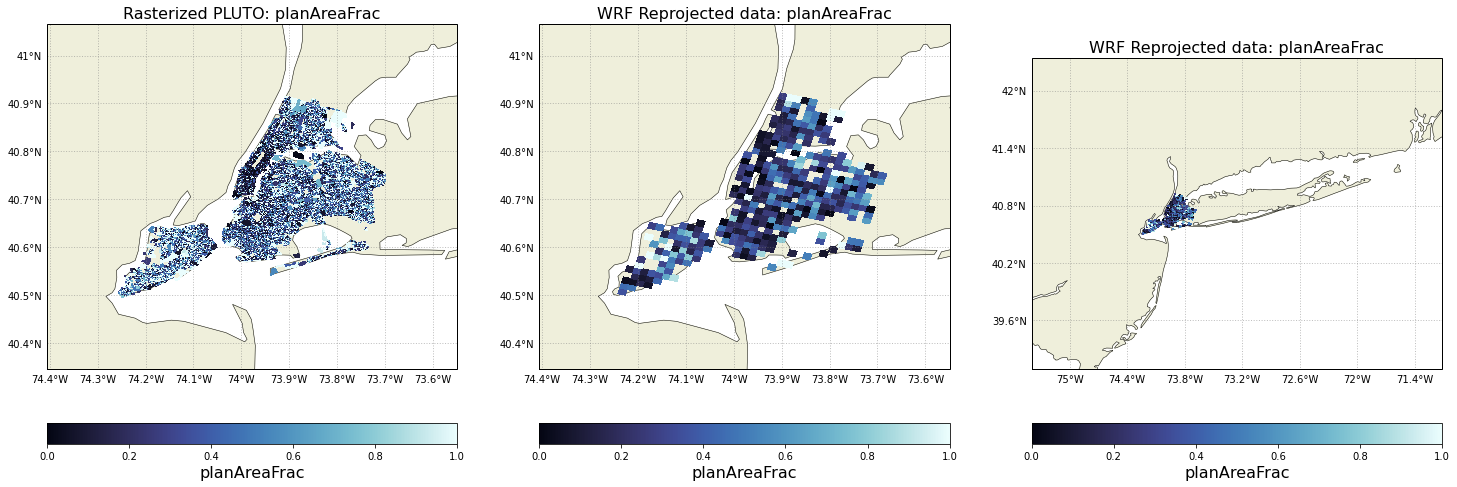

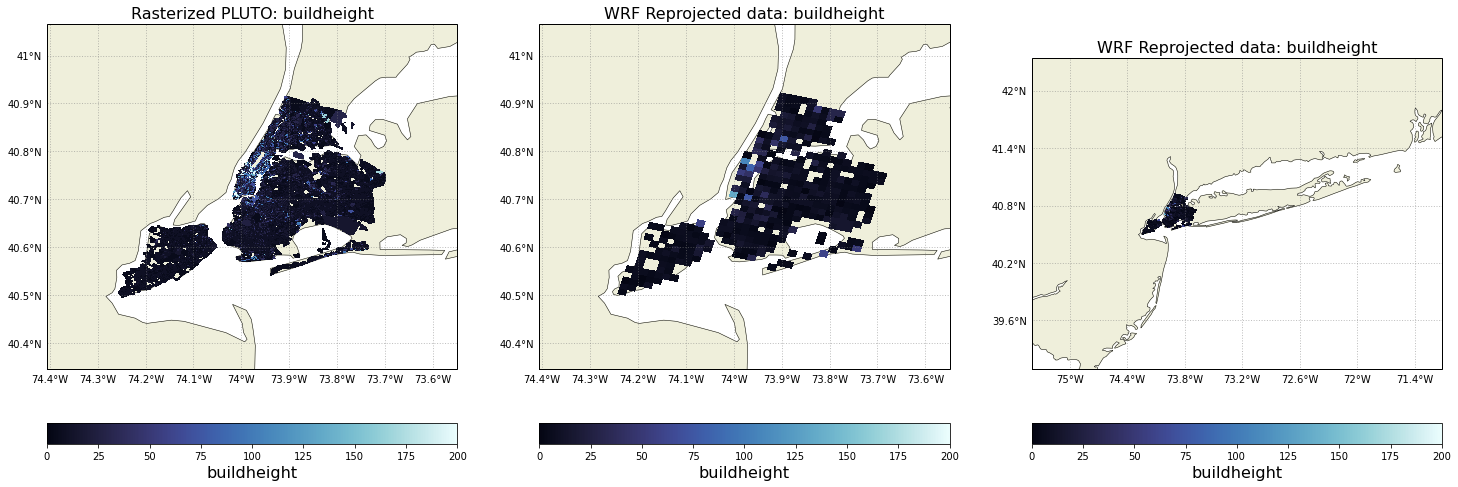

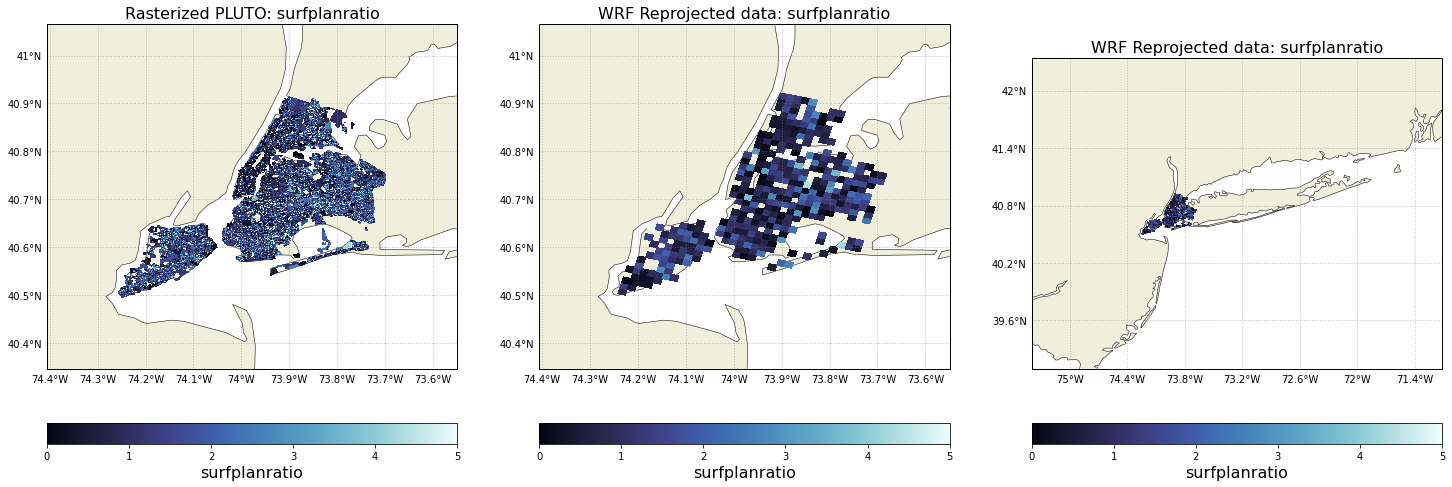

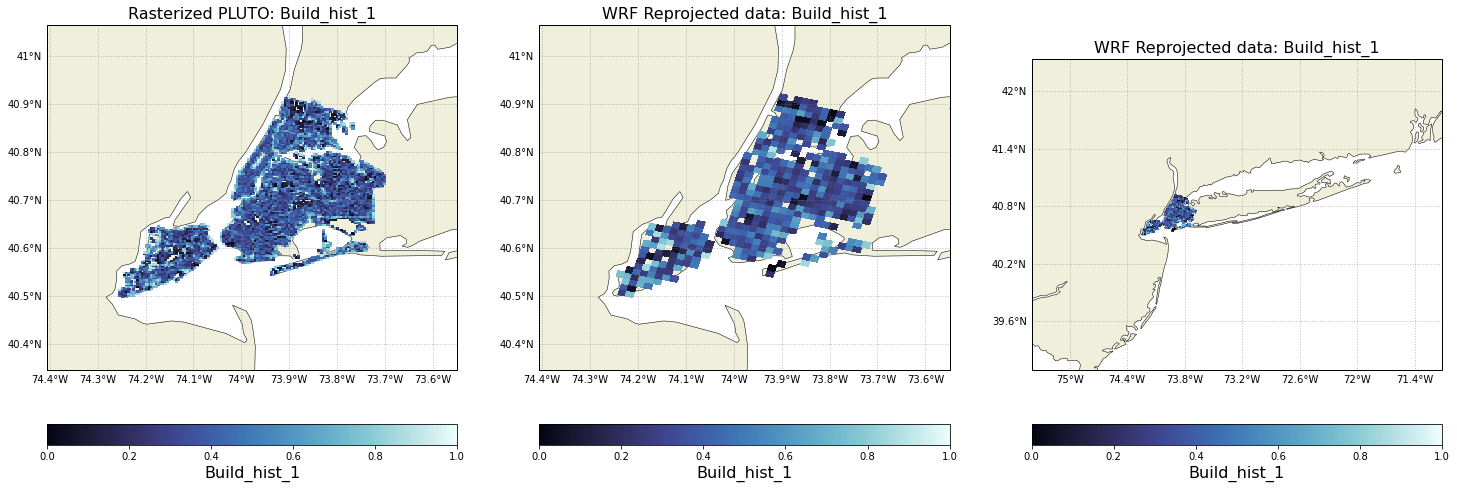

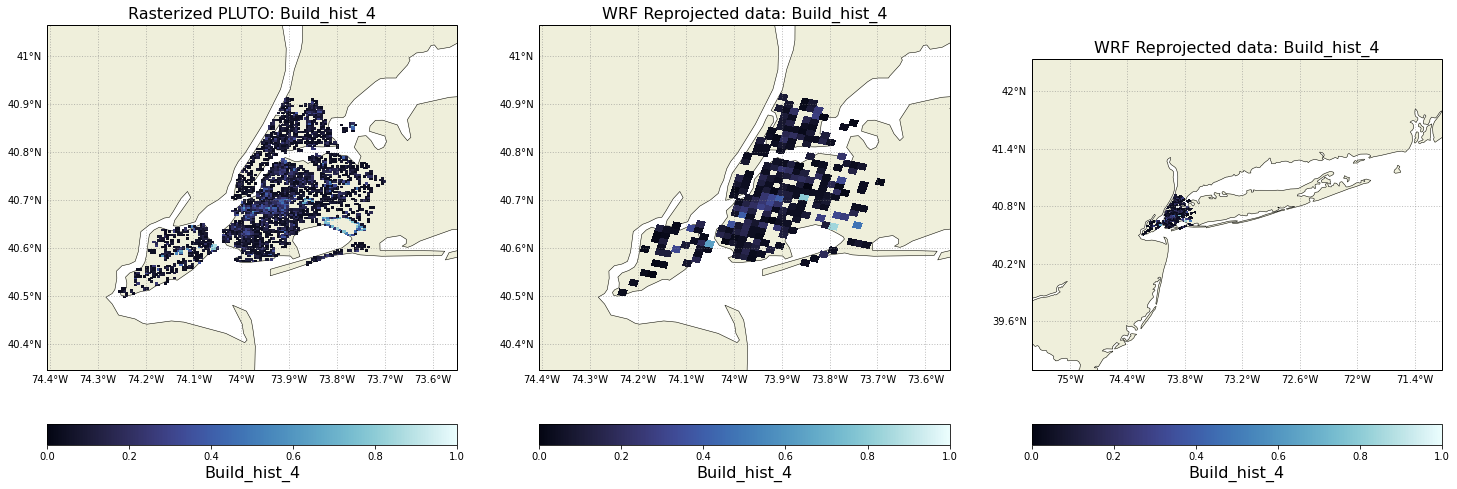

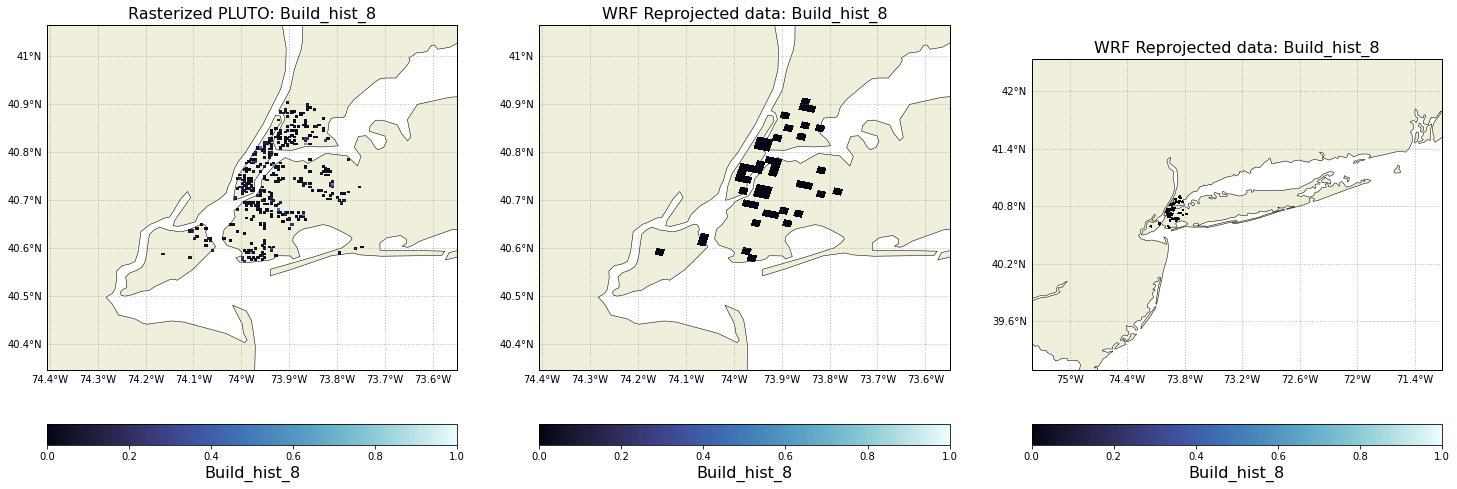

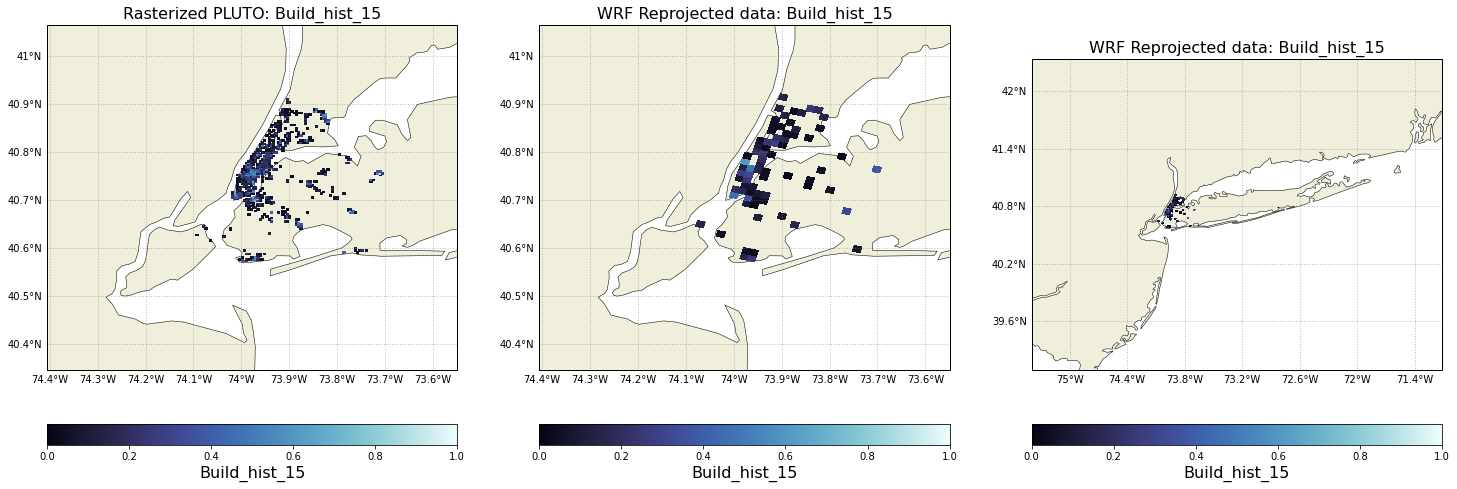

In [82]:
VAR_NAME='planAreaFrac'
plot_data_pluto=np.ma.masked_where(planAreaFrac == 0 , planAreaFrac)
plot_data_WRF=np.ma.masked_where(GEO_EM_DATA.URB_PARAM.data[:,90,:,:].squeeze() == 0 , GEO_EM_DATA.URB_PARAM.data[:,90,:,:].squeeze())
wrf_long=GEO_EM_DATA.XLONG_M.data.squeeze()
wrf_lat=GEO_EM_DATA.XLAT_M.data.squeeze()
Plot_both_data(VAR_NAME,plot_data_pluto,plot_data_WRF,wrf_long,wrf_lat,0,1)

VAR_NAME='buildheight'
plot_data_pluto=np.ma.masked_where(buildheight == 0 , buildheight)
plot_data_WRF=np.ma.masked_where(GEO_EM_DATA.URB_PARAM.data[:,93,:,:].squeeze() == 0 , GEO_EM_DATA.URB_PARAM.data[:,93,:,:].squeeze())
wrf_long=GEO_EM_DATA.XLONG_M.data.squeeze()
wrf_lat=GEO_EM_DATA.XLAT_M.data.squeeze()
Plot_both_data(VAR_NAME,plot_data_pluto,plot_data_WRF,wrf_long,wrf_lat,0,200)

VAR_NAME='surfplanratio'
plot_data_pluto=np.ma.masked_where(surfplanratio == 0 , surfplanratio)
plot_data_WRF=np.ma.masked_where(GEO_EM_DATA.URB_PARAM.data[:,94,:,:].squeeze() == 0 , GEO_EM_DATA.URB_PARAM.data[:,94,:,:].squeeze())
wrf_long=GEO_EM_DATA.XLONG_M.data.squeeze()
wrf_lat=GEO_EM_DATA.XLAT_M.data.squeeze()
Plot_both_data(VAR_NAME,plot_data_pluto,plot_data_WRF,wrf_long,wrf_lat,0,5)

VAR_NAME='Build_hist_1'
plot_data_pluto=np.ma.masked_where(buildheighthist[:,:,0] == 0 , buildheighthist[:,:,0])
plot_data_WRF=np.ma.masked_where(GEO_EM_DATA.URB_PARAM.data[:,117,:,:].squeeze() == 0 , GEO_EM_DATA.URB_PARAM.data[:,117,:,:].squeeze())
wrf_long=GEO_EM_DATA.XLONG_M.data.squeeze()
wrf_lat=GEO_EM_DATA.XLAT_M.data.squeeze()
Plot_both_data(VAR_NAME,plot_data_pluto,plot_data_WRF,wrf_long,wrf_lat,0,1)

VAR_NAME='Build_hist_4'
plot_data_pluto=np.ma.masked_where(buildheighthist[:,:,3] == 0 , buildheighthist[:,:,3])
plot_data_WRF=np.ma.masked_where(GEO_EM_DATA.URB_PARAM.data[:,120,:,:].squeeze() == 0 , GEO_EM_DATA.URB_PARAM.data[:,120,:,:].squeeze())
wrf_long=GEO_EM_DATA.XLONG_M.data.squeeze()
wrf_lat=GEO_EM_DATA.XLAT_M.data.squeeze()
Plot_both_data(VAR_NAME,plot_data_pluto,plot_data_WRF,wrf_long,wrf_lat,0,1)

VAR_NAME='Build_hist_8'
plot_data_pluto=np.ma.masked_where(buildheighthist[:,:,7] == 0 , buildheighthist[:,:,7])
plot_data_WRF=np.ma.masked_where(GEO_EM_DATA.URB_PARAM.data[:,124,:,:].squeeze() == 0 , GEO_EM_DATA.URB_PARAM.data[:,12,:,:].squeeze())
wrf_long=GEO_EM_DATA.XLONG_M.data.squeeze()
wrf_lat=GEO_EM_DATA.XLAT_M.data.squeeze()
Plot_both_data(VAR_NAME,plot_data_pluto,plot_data_WRF,wrf_long,wrf_lat,0,1)

VAR_NAME='Build_hist_15'
plot_data_pluto=np.ma.masked_where(buildheighthist[:,:,14] == 0 , buildheighthist[:,:,14])
plot_data_WRF=np.ma.masked_where(GEO_EM_DATA.URB_PARAM.data[:,131,:,:].squeeze() == 0 , GEO_EM_DATA.URB_PARAM.data[:,131,:,:].squeeze())
wrf_long=GEO_EM_DATA.XLONG_M.data.squeeze()
wrf_lat=GEO_EM_DATA.XLAT_M.data.squeeze()
Plot_both_data(VAR_NAME,plot_data_pluto,plot_data_WRF,wrf_long,wrf_lat,0,1)